# Assignment 2
In this assignment you will be writing netunicorn experiments to measure 'latency-under-load'.  

## Due Date: November 8th    
Please submit a PDF verion of this notebook with all the cells evaluated and answers displayed.  

In [2]:
import os
import time
import random
import time
import requests 
import re
import logging
import subprocess
from subprocess import Popen
from sys import platform
import os, sys
import logging
import json
import threading
import numpy as np

import subprocess
import time
import signal
from typing import Dict

from netunicorn.base.architecture import Architecture
from netunicorn.base.nodes import Node
from netunicorn.base.task import Failure, Task, TaskDispatcher


from netunicorn.client.remote import RemoteClient, RemoteClientException
from netunicorn.base import Experiment, ExperimentStatus, Pipeline
from netunicorn.library.tasks.basic import SleepTask
from netunicorn.library.tasks.measurements.ookla_speedtest import SpeedTest
from netunicorn.library.tasks.measurements.ping import Ping
from netunicorn.base.architecture import Architecture
from netunicorn.base.nodes import Node
from netunicorn.base.task import Failure, Task, TaskDispatcher
from netunicorn.base import Result, Failure, Success, Task, TaskDispatcher
from netunicorn.base.architecture import Architecture
from netunicorn.base.nodes import Node

from typing import Dict
from typing import Optional
from enum import IntEnum
from datetime import datetime

from returns.pipeline import is_successful
from returns.result import Failure

### Helper Functions
We have defined two helper functions for executing pipelines and displaying the results from the pipeline execution that you may use.

In [3]:
def execute_pipeline(pipeline, working_node, experiment_label):
    client = RemoteClient(endpoint=NETUNICORN_ENDPOINT, login=NETUNICORN_LOGIN, password=NETUNICORN_PASSWORD)
    nodes = client.get_nodes()
    working_nodes = nodes.filter(lambda node: node.name.startswith(working_node)).take(1)
    experiment = Experiment().map(pipeline, working_nodes)

    try:
        client.delete_experiment(experiment_label)
    except RemoteClientException:
        pass

    # Prepare Experiment
    client.prepare_experiment(experiment, experiment_label)
    while True:
        info = client.get_experiment_status(experiment_label)
        print(info.status)
        if info.status == ExperimentStatus.READY:
            break
        time.sleep(20)

    time.sleep(5)

    # Execute Experiment
    client.start_execution(experiment_label)
    while True:
        info = client.get_experiment_status(experiment_label)
        print(info.status)
        if info.status != ExperimentStatus.RUNNING:
            break
        time.sleep(20)
    return info

In [4]:
def display_results(info):
    # Get Results
    for report in info.execution_result:
        print(f"Node name: {report.node.name}")
        print(f"Error: {report.error}")

        if report.result is None:
            print("report.result is EMPTY..")
            continue

        result, log = report.result  # report stores results of execution and corresponding log

        # result is a returns.result.Result object, could be Success of Failure
        print(f"Result is: {type(result)}")
        if is_successful(result):
            data = result.unwrap()
        else:
            data = result.failure()
        try:
            for key, value in data.items():
                print(f"{key}: {value}")
        except:
            print(f"No attribute 'items' in result")

        # we also can explore logs
        for line in log:
            print(line.strip())
        print()

### Task 0
Set your credentials for accessing the UCSB netUnicorn deployment below. View the working nodes and choose 1 working node that you will be using for this assignment.

In [5]:
# TODO: fill in your login / password below
netunicorn_login = 'cs190n7'
netunicorn_password = 'xFunhnNh'

NETUNICORN_ENDPOINT = os.environ.get('NETUNICORN_ENDPOINT', 'https://pinot.cs.ucsb.edu/netunicorn')
NETUNICORN_LOGIN = os.environ.get('NETUNICORN_LOGIN', netunicorn_login)
NETUNICORN_PASSWORD = os.environ.get('NETUNICORN_PASSWORD', netunicorn_password)

client = RemoteClient(endpoint=NETUNICORN_ENDPOINT, login=NETUNICORN_LOGIN, password=NETUNICORN_PASSWORD)
print("Health Check: {}".format(client.healthcheck()))
nodes = client.get_nodes()
print(nodes)

Health Check: True
[<Uncountable node pool with next node template: [aws-fargate-A-cs190n7-, aws-fargate-B-cs190n7-, aws-fargate-ARM64-cs190n7-]>]


In [6]:
# TODO: fill in the name of your working node
working_node = 'aws-fargate-A-cs190n7-'

In [7]:
print("Selected working node:", working_node)

Selected working node: aws-fargate-A-cs190n7-


### Task 1
Create a pipeline to collect latency data to Google's public DNS (8.8.8.8) from your working node using the [Ping](https://github.com/netunicorn/netunicorn-library/blob/main/tasks/measurements/ping.py) task.   
Report the average latency over 5 ICMP probes to the address 8.8.8.8

In [8]:
# TODO: fill in the correct arguments for the Ping() task
pipeline = (
    Pipeline()
    .then(Ping(address="8.8.8.8",count=5))
)

In [8]:
info = execute_pipeline(pipeline, working_node, 'ping_experiment')
display_results(info)

ExperimentStatus.PREPARING
ExperimentStatus.PREPARING
ExperimentStatus.READY
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.FINISHED
Node name: aws-fargate-A-cs190n7-1
Error: None
Result is: <class 'returns.result.Success'>
36eb7f75-c778-4a96-94b1-229bb59de9ff: [<Success: PingResult(host='8.8.8.8', packets=[PacketResult(icmp_seq=1, ttl=118, time=1.38, unit='ms'), PacketResult(icmp_seq=2, ttl=118, time=1.37, unit='ms'), PacketResult(icmp_seq=3, ttl=118, time=1.41, unit='ms'), PacketResult(icmp_seq=4, ttl=118, time=1.36, unit='ms'), PacketResult(icmp_seq=5, ttl=118, time=1.38, unit='ms')], packet_loss=0.0, min_rtt=1.359, avg_rtt=1.378, max_rtt=1.409, stddev_rtt=0.017, unit_rtt='ms', unparsed_output=[], raw_output='PING 8.8.8.8 (8.8.8.8) 56(84) bytes of data.\n64 bytes from 8.8.8.8: icmp_seq=1 ttl=118 time=1.38 ms\n64 bytes from 8.8.8.8: icmp_seq=2 ttl=118 time=1.37 ms\n64 bytes from 8.8.8.8: icmp_seq=3 ttl=118 time=1.41 ms\n64 bytes from 8.8.8.8: icmp_seq=4 ttl=118 ti

In [9]:
# TODO: Fill the latency samples array with the latency values returned by the Ping task
latency_samples = [
    1.38,  # icmp_seq=1
    1.37,  # icmp_seq=2
    1.41,  # icmp_seq=3
    1.36,  # icmp_seq=4
    1.38   # icmp_seq=5
]
print("Average Latency: {:.4f} ms".format(np.mean(latency_samples)))

Average Latency: 1.3800 ms


### Task 2
Now we will define a new task, StartBackgroundPing that behaves similar to the Ping task, however it starts the process in the background, so further tasks in the pipeline will execute in parallel with our latency measurements.  

Implement the **run()** function in the **StartBackgroundPingLinuxImplementation** class

In [10]:
class StartBackgroundPing(TaskDispatcher):
    def __init__(self, address: str, filepath: str, timeout: int = 120, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.address = address
        self.filepath = filepath
        self.timeout = timeout
        self.linux_implementation = StartBackgroundPingLinuxImplementation(
            address=self.address,
            filepath=self.filepath,
            timeout=self.timeout,
            *args,
            **kwargs
        )

    def dispatch(self, node: Node) -> Task:
        if node.architecture in {Architecture.LINUX_AMD64, Architecture.LINUX_ARM64}:
            return self.linux_implementation
        raise NotImplementedError(
            f'StartBackgroundPing is not implemented for architecture: {node.architecture}'
        )

class StartBackgroundPingLinuxImplementation(Task):
    def __init__(self, address: str, filepath: str, timeout: int = 120, *args, **kwargs):
        self.address = address.strip()
        self.filepath = filepath
        self.timeout = timeout
        super().__init__(*args, **kwargs)
    
    # TODO: implement the run() function
    def run(self):
        # 1. open self.filepath in write mode
        outfile = open(self.filepath, "w")  # Corrected here with "w" as a string

        # 2. Set the `args` argument for Popen to execute the command `ping -t self.timeout`
        # 3. Set the optional arguments stdout and stderr to the file object opened for self.filepath
        proc = subprocess.Popen(
            ['ping', '-w', str(self.timeout), self.address],
            stdout=outfile,
            stderr=outfile
        )
        
        time.sleep(2)
        if (exit_code := proc.poll()) is None:  # not finished yet
            return Success(proc.pid)
        return Failure(f"StartBackgroundPing failed with return code {exit_code}")

Below, we define a complementary task, StopBackgroundPing to kill our ping process so it doesn't always execute until the timeout. By specifying an optional argument `name` to our StartBackgroundPing task, we can look up the results for this task using the `self.previous_steps` object, to retrieve the PID of the ping process that we return in the StartBackgroundPing task.

In [11]:
class StopBackgroundPing(TaskDispatcher):
    def __init__(self, start_ping_task_name : str, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.start_ping_task_name = start_ping_task_name
        self.linux_implementation = StopBackgroundPingLinuxImplementation(
            ping_task_name=self.start_ping_task_name,
            *args,
            **kwargs,
        )
    def dispatch(self, node: Node) -> Task:
        if node.architecture in {Architecture.LINUX_AMD64, Architecture.LINUX_ARM64}:
            return self.linux_implementation

        raise NotImplementedError(
            f'StopBackgroundPing is not implemented for {node.architecture}'
        )

class StopBackgroundPingLinuxImplementation(Task):
    requirements = ["sudo apt-get update", "sudo apt-get install -y tcpdump", "sudo apt-get install -y procps"]

    def __init__(self, ping_task_name: str, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ping_task_name = ping_task_name

    def run(self):
        signal.signal(signal.SIGCHLD, signal.SIG_IGN)
        pid = self.previous_steps.get(self.ping_task_name, [Failure("Named StartBackgroundPing not found")])[-1]
        if isinstance(pid, Failure):
            return pid

        pid = pid.unwrap()
        return subprocess.check_output(["kill", str(pid)])

### Task 3
Now we will define a new task, GetFileContents that will output the results that we wrote to a file in the StartBackgroundPing task. This task simply prints the content of a file to stdout.

Implement the **run()** function in the **GetFileContents** class

In [12]:
class GetFileContents(TaskDispatcher):
    def __init__(self, filepath: str, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linux_implementation = GetFileContentsLinuxImplementation(
            filepath=filepath, name=self.name
        )

    def dispatch(self, node: Node) -> Task:
        if node.architecture in {Architecture.LINUX_AMD64, Architecture.LINUX_ARM64}:
            return self.linux_implementation
        raise NotImplementedError(
            f"GetFileContents is not implemented for architecture: {node.architecture}"
        )

class GetFileContentsLinuxImplementation(Task):
    def __init__(self, filepath: str, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.filepath = filepath

    # TODO: implement the run() function
    def run(self):
        # 1. set the arguments for subprocess.run to exectue the command `cat self.filepath`
        # 2. set the optional argument `capture_output` to True so that stdout will be captured
        result = subprocess.run(['cat', self.filepath], capture_output=True)
        
        if result.returncode != 0:
            return Failure(
                result.stdout.decode("utf-8").strip()
                + "\n"
                + result.stderr.decode("utf-8").strip()
            )

        return result.stdout.decode("utf-8")

### Task 4
Collect latency samples to 8.8.8.8 using the new tasks we've defined. The pipeline has already been defined for you below, but requires that the StartBackgroundPing and GetFileContents tasks are implemented correctly. Plot the results. The x-axis should be the ICMP sequence number (icmp_seq), and the y-axis should the latency in milliseconds. You should observe similar values to what you observed from Task 1.

In [13]:
pipeline = (
    Pipeline()
    .then(StartBackgroundPing(address='8.8.8.8', filepath="/tmp/background_ping_results1.txt", name="background_ping"))
    .then(SleepTask(30))
    .then(StopBackgroundPing(start_ping_task_name="background_ping"))
    .then(SleepTask(2))
    .then(GetFileContents(filepath="/tmp/background_ping_results1.txt"))
)

In [14]:
info = execute_pipeline(pipeline, working_node, 'background_ping_experiment')
display_results(info)

ExperimentStatus.PREPARING
ExperimentStatus.PREPARING
ExperimentStatus.READY
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.FINISHED
Node name: aws-fargate-A-cs190n7-1
Error: None
Result is: <class 'returns.result.Success'>
background_ping: [<Success: 9>]
ea645476-4c72-40a7-b7c1-590a46af6f08: [<Success: 30>]
0b64ccad-5ccf-4afa-a5fc-451e6bb382b2: [<Success: b''>]
0ef673ef-9f79-4113-aec0-0c4259247999: [<Success: 2>]
3fc69fad-7563-4511-9cde-fc7ebdb87dbb: [<Success: PING 8.8.8.8 (8.8.8.8) 56(84) bytes of data.
64 bytes from 8.8.8.8: icmp_seq=1 ttl=118 time=1.90 ms
64 bytes from 8.8.8.8: icmp_seq=2 ttl=118 time=1.36 ms
64 bytes from 8.8.8.8: icmp_seq=3 ttl=118 time=1.46 ms
64 bytes from 8.8.8.8: icmp_seq=4 ttl=118 time=1.32 ms
64 bytes from 8.8.8.8: icmp_seq=5 ttl=118 time=1.31 ms
64 bytes from 8.8.8.8: icmp_seq=6 ttl=118 time=1.34 ms
64 bytes from 8.8.8.8: icmp_seq=7 ttl=118 time=1.36 ms
64 bytes from 8.8.8.8: icmp_seq=8 ttl=118 time=1.34 ms
64 

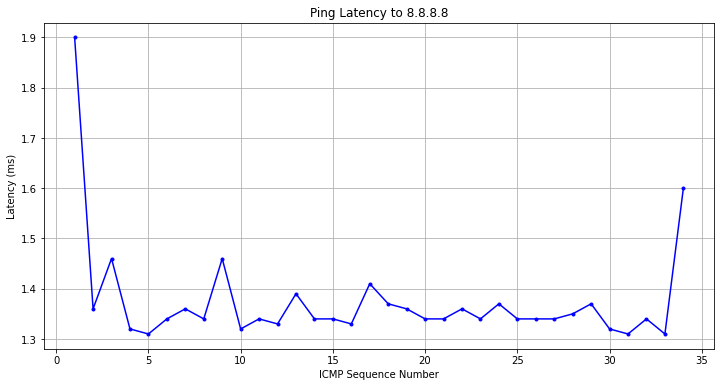

In [15]:
# TODO
# 1. Parse netUnicorn output
# 2. Graph Results
import re
import matplotlib.pyplot as plt

def parse_and_plot(output:str):
    # Parse the data using regular expressions
    pattern = r'icmp_seq=(\d+).*time=([\d.]+) ms'
    seq_numbers = []
    latencies = []

    for line in output.split('\n'):
        match = re.search(pattern, line)
        if match:
            seq_num = int(match.group(1))
            latency = float(match.group(2))
            seq_numbers.append(seq_num)
            latencies.append(latency)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(seq_numbers, latencies, 'b.-', label='Latency')
    plt.xlabel('ICMP Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.title('Ping Latency to 8.8.8.8')
    plt.grid(True)
    plt.show()

#     # Print some statistics
#     print(f"Average latency: {sum(latencies)/len(latencies):.2f} ms")
#     print(f"Min latency: {min(latencies):.2f} ms")
#     print(f"Max latency: {max(latencies):.2f} ms")

parse_and_plot(str(info))

### Task 5
Now we will use the SpeedTest task to induce extra load on the network, and simultaneously collect our lateny samples. The pipeline has already been defined for you below, but requires that the StartBackgroundPing and GetFileContents tasks are implemented correctly. Plot the results alongside the results from Task 4. The x-axis should be the ICMP sequence number (icmp_seq), and the y-axis should the latency in milliseconds.

In [16]:
pipeline = (
    Pipeline()
    .then(StartBackgroundPing(address='8.8.8.8', filepath="/tmp/background_ping_results2.txt", name="background_ping_under_load"))
    .then(SpeedTest())
    .then(StopBackgroundPing(start_ping_task_name="background_ping_under_load"))
    .then(SleepTask(2))
    .then(GetFileContents(filepath="/tmp/background_ping_results2.txt"))
)

In [17]:
info_with_load = execute_pipeline(pipeline, working_node, 'background_ping_under_load_experiment')
display_results(info_with_load)

ExperimentStatus.PREPARING
ExperimentStatus.PREPARING
ExperimentStatus.READY
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.FINISHED
Node name: aws-fargate-A-cs190n7-1
Error: None
Result is: <class 'returns.result.Success'>
background_ping_under_load: [<Success: 8>]
994b73aa-57a3-4623-a05a-a487fa48dcb8: [<Success: {'ping': {'value': 3.141, 'unit': 'ms'}, 'download': {'value': 365.97, 'unit': 'Mbit/s'}, 'upload': {'value': 308.44, 'unit': 'Mbit/s'}, 'other': ['', '']}>]
17f5fb8d-6642-4d60-bb09-0afc048e4133: [<Success: b''>]
5b0267e8-c245-4d69-9c71-b5d25617d8a5: [<Success: 2>]
cc8d1ed1-b67f-4912-a544-4a5a8f7e8478: [<Success: PING 8.8.8.8 (8.8.8.8) 56(84) bytes of data.
64 bytes from 8.8.8.8: icmp_seq=1 ttl=118 time=1.35 ms
64 bytes from 8.8.8.8: icmp_seq=2 ttl=118 time=1.35 ms
64 bytes from 8.8.8.8: icmp_seq=3 ttl=118 time=1.35 ms
64 bytes from 8.8.8.8: icmp_seq=4 ttl=118 time=1.37 ms
64 bytes from 8.8.8.8: icmp_seq=5 

In [18]:
import re
import matplotlib.pyplot as plt

def parse_and_plot(output1: str, output2: str, label1: str = "Latency without Load", label2: str = "Latency with Load"):
    # Regular expression to match ICMP sequence and latency time in milliseconds
    pattern = r'icmp_seq=(\d+).*time=([\d.]+) ms'

    # Parse the first output
    seq_numbers1 = []
    latencies1 = []
    for line in output1.split('\n'):
        match = re.search(pattern, line)
        if match:
            seq_num = int(match.group(1))
            latency = float(match.group(2))
            seq_numbers1.append(seq_num)
            latencies1.append(latency)

    # Parse the second output
    seq_numbers2 = []
    latencies2 = []
    for line in output2.split('\n'):
        match = re.search(pattern, line)
        if match:
            seq_num = int(match.group(1))
            latency = float(match.group(2))
            seq_numbers2.append(seq_num)
            latencies2.append(latency)

    # Create the plot with both sets of data
    plt.figure(figsize=(12, 6))
    
    # Plot the first set (without load)
    plt.plot(seq_numbers1, latencies1, 'b.-', label=label1)
    
    # Plot the second set (with load)
    plt.plot(seq_numbers2, latencies2, 'r.-', label=label2)
    
    # Add labels and title
    plt.xlabel('ICMP Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.title('Ping Latency to 8.8.8.8 with and without Network Load')
    plt.grid(True)
    plt.legend()
    plt.show()

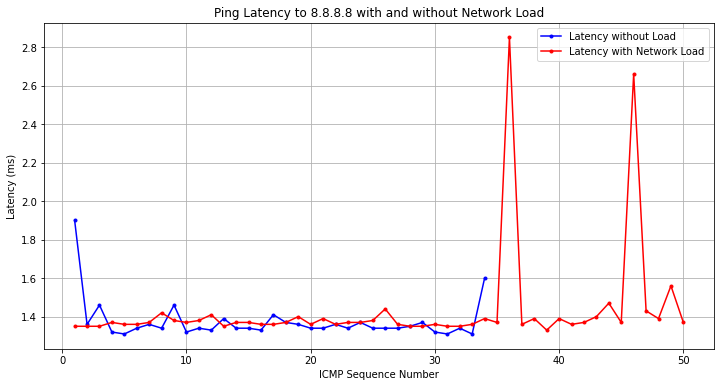

In [19]:
# TODO
# 1. Parse netUnicorn output
# 2. Graph Results alongside Task 4
# Parse the data using regular expressions
parse_and_plot(str(info), str(info_with_load), "Latency without Load", "Latency with Network Load")



### Task 6
Do you observe a difference in latencies between Task 4 and Task 5? If so, what is the reason that we observe an increased latency when we are simultaneously running a speedtest?

Explain your answer to Task 6 below.

### Observations

1. **Increased Average Latency with Load**: The red line, representing latency with network load, generally shows higher values compared to the blue line (without load). This suggests that network congestion impacts latency.

2. **Latency Spikes under Load**: The red line has noticeable spikes around ICMP sequence numbers 30 and 45, where latency jumps significantly (up to around 2.8 ms). These spikes are not present in the latency data without load, indicating that the `SpeedTest` task (used to generate load) creates periods of high congestion, causing packets to experience longer delays.

3. **Stable Latency without Load**: The blue line remains relatively flat, with only minor fluctuations. This demonstrates that, in the absence of competing network traffic, the latency to Google’s DNS (8.8.8.8) is stable and low, averaging around 1.4 ms.

### Explanation of Increased Latency under Load

The increased latency and the presence of latency spikes in the red line can be attributed to the following reasons:

1. **Network Congestion**: Running the `SpeedTest` task generates a large amount of network traffic as it measures upload and download speeds. This traffic competes for bandwidth with the ping packets, causing congestion. As a result, ping packets are delayed, leading to increased latency.

2. **Queueing Delays**: Due to the heavy network load from `SpeedTest`, packets are queued in the network stack. This queueing effect is especially visible at points where latency spikes, indicating that packets are waiting longer to be transmitted.

3. **Resource Contention**: When the network is under load, resources such as the router buffer and network interface queues are heavily used by the `SpeedTest` traffic, resulting in delays for the ping packets.

### Summary

This experiment clearly demonstrates how network-intensive tasks can impact latency-sensitive applications. The additional load caused by `SpeedTest` leads to both increased average latency and occasional high spikes in latency. This highlights the importance of considering network load when designing or testing latency-sensitive applications, as even intermittent heavy traffic can lead to noticeable delays.